In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

In [4]:
# Load pre-trained BERT tokenizer and model for sequence classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels for binary classification (positive/negative)

# Load a sentiment analysis dataset (IMDb movie reviews)
dataset = load_dataset('imdb')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [13]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets.set_format('torch')

train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

In [15]:
print(tokenized_datasets['train'])

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


In [7]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
from torch.optim import AdamW

model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
# Set the model to training mode
model.train()

# Number of epochs
epochs = 3

# To store the loss values for plotting later
loss_values = []

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print whether we're using the GPU
if torch.cuda.is_available():
    print("Training on GPU")
else:
    print("Training on CPU")

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    
    # Loop over batches
    for batch in train_dataloader:
        # Move the batch to the GPU if available
        batch = {k: v.to(device) for k, v in batch.items()}

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Perform a forward pass (get predictions)
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['label'])

        loss = outputs.loss

        # Perform backpropagation to calculate gradients
        loss.backward()

        # Update parameters using optimizer
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()
    
    # Calculate average loss over the epoch
    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Average loss for epoch {epoch + 1}: {avg_loss}")


Training on GPU
Epoch 1/3
Average loss for epoch 1: 0.2712182348847389
Epoch 2/3
Average loss for epoch 2: 0.1589650314686075
Epoch 3/3
Average loss for epoch 3: 0.10064060132112354


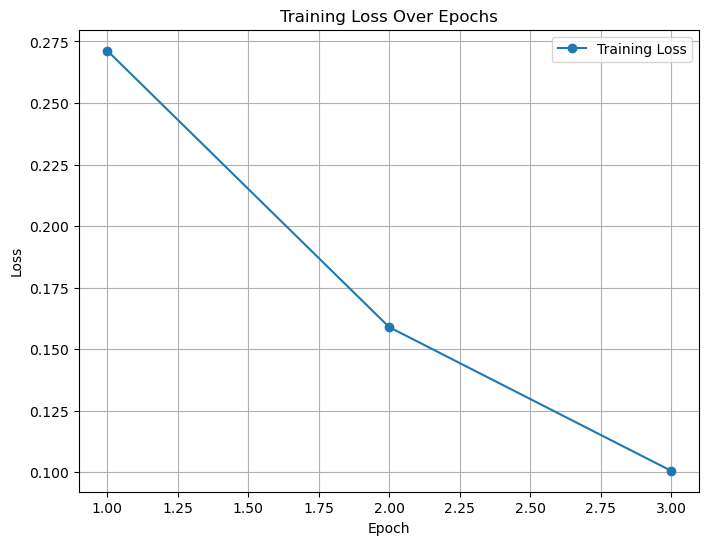

In [17]:
# Plot the loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Save the model
model.save_pretrained('sentiment-analysis-bert')

# Save the tokenizer
tokenizer.save_pretrained('sentiment-analysis-bert')

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


In [20]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track predictions and true labels
correct_predictions = 0
total_predictions = 0

# Disable gradient calculations for evaluation (faster and uses less memory)
with torch.no_grad():
    for batch in test_dataloader:
        # Move the batch to the GPU if available
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform a forward pass (get predictions)
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Get the predicted class (logits are raw scores before softmax)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Compare predictions to the true labels
        correct_predictions += (predictions == batch['label']).sum().item()
        total_predictions += batch['label'].size(0)

# Calculate and print the accuracy
accuracy = correct_predictions / total_predictions
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

Accuracy on the test set: 91.35%
